In [1]:
% matplotlib inline
from yahoo_finance import Share
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from bn_class import *


In [2]:
"""Hyperparameters"""
num_filt_1 = 15     #Number of filters in first conv layer
num_filt_2 = 8      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 1024     #Number of neurons in hully connected layer
max_iterations = 8000
model_num=7         #Number of model used for voting
voting_times=3      #Threshold of voting
batch_size = 100
dropout = 0.5       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
regularization = 1e-4
learning_rate = 2e-3
input_norm = False   # Do you want z-score input normalization?
np.set_printoptions(threshold=np.inf)#print full array

In [3]:
dataset = "2330"
datadir = 'data/'+ dataset
data_train = np.loadtxt(datadir+'_train_15',delimiter=',')
data_test_val = np.loadtxt(datadir+'_test',delimiter=',')
data_test=data_test_val

## split training and testing data

In [4]:
X_train = data_train[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_test = data_test[:,0]

## normalize x and y

In [5]:
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9

In [6]:
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))


Train with approximately 1467 epochs


## place for the input variables

Training at model 0
 Training accuracy at 0 out of 8000 is 0.2
 Training accuracy at 1000 out of 8000 is 0.952294
 Training accuracy at 2000 out of 8000 is 0.957798
 Training accuracy at 3000 out of 8000 is 0.979816
 Training accuracy at 4000 out of 8000 is 0.988991
 Training accuracy at 5000 out of 8000 is 0.99633
 Training accuracy at 6000 out of 8000 is 0.99633
 Training accuracy at 7000 out of 8000 is 1.0
Training at model 1
 Training accuracy at 0 out of 8000 is 0.8
 Training accuracy at 1000 out of 8000 is 0.955963
 Training accuracy at 2000 out of 8000 is 0.954128
 Training accuracy at 3000 out of 8000 is 0.955963
 Training accuracy at 4000 out of 8000 is 0.968807
 Training accuracy at 5000 out of 8000 is 0.990826
 Training accuracy at 6000 out of 8000 is 0.994495
 Training accuracy at 7000 out of 8000 is 0.998165
Training at model 2
 Training accuracy at 0 out of 8000 is 0.337615
 Training accuracy at 1000 out of 8000 is 0.954128
 Training accuracy at 2000 out of 8000 is 0.9559

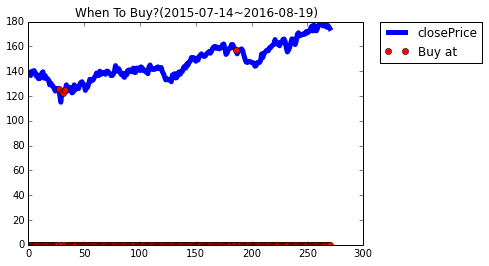

In [7]:
total_rst=np.zeros((model_num,len(y_test)), dtype=np.float)
for xx in xrange(0,model_num):
  print("Training at model "+str(xx))
  x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
  y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
  keep_prob = tf.placeholder("float")
  bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

  ## w and b and conv function
  def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

  def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

  with tf.name_scope("Reshaping_data") as scope:
    x_image = tf.reshape(x, [-1,D,1,1])

  ## Build the graph
  # ewma is the decay for which we update the moving average of the 
  # mean and variance in the batch-norm layers
  with tf.name_scope("Conv1") as scope:
    W_conv1 = weight_variable([4, 1, 1, num_filt_1], 'Conv_Layer_1')
    b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
    a_conv1 = conv2d(x_image, W_conv1) + b_conv1
    
  with tf.name_scope('Batch_norm_conv1') as scope:
      ewma = tf.train.ExponentialMovingAverage(decay=0.99)                  
      bn_conv1 = ConvolutionalBatchNormalizer(num_filt_1, 0.001, ewma, True)           
      update_assignments = bn_conv1.get_assigner() 
      a_conv1 = bn_conv1.normalize(a_conv1, train=bn_train) 
      h_conv1 = tf.nn.relu(a_conv1)
    
  with tf.name_scope("Conv2") as scope:
    W_conv2 = weight_variable([4, 1, num_filt_1, num_filt_2], 'Conv_Layer_2')
    b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
    a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2
    
  with tf.name_scope('Batch_norm_conv2') as scope:
      bn_conv2 = ConvolutionalBatchNormalizer(num_filt_2, 0.001, ewma, True)           
      update_assignments = bn_conv2.get_assigner() 
      a_conv2 = bn_conv2.normalize(a_conv2, train=bn_train) 
      h_conv2 = tf.nn.relu(a_conv2)
      
  with tf.name_scope("Conv3") as scope:
    W_conv3 = weight_variable([4, 1, num_filt_2, num_filt_3], 'Conv_Layer_3')
    b_conv3 = bias_variable([num_filt_3], 'bias_for_Conv_Layer_3')
    a_conv3 = conv2d(h_conv2, W_conv3) + b_conv3
    
  with tf.name_scope('Batch_norm_conv3') as scope:
      bn_conv3 = ConvolutionalBatchNormalizer(num_filt_3, 0.001, ewma, True)           
      update_assignments = bn_conv3.get_assigner() 
      a_conv3 = bn_conv3.normalize(a_conv3, train=bn_train) 
      h_conv3 = tf.nn.relu(a_conv3)

  with tf.name_scope("Fully_Connected1") as scope:
    W_fc1 = weight_variable([D*num_filt_3, num_fc_1], 'Fully_Connected_layer_1')
    b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
    h_conv3_flat = tf.reshape(h_conv3, [-1, D*num_filt_3])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)
    
  with tf.name_scope("Fully_Connected2") as scope:
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = tf.Variable(tf.truncated_normal([num_fc_1, num_classes], stddev=0.1),name = 'W_fc2')
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
    h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2   
  with tf.name_scope("SoftMax") as scope:
      regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
                    tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) + 
                    tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
                    tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) + 
                    tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))

      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
      cost = tf.reduce_sum(loss) / batch_size
      cost += regularization*regularizers
 
  ## define train optimizer##
  with tf.name_scope("train") as scope:
      tvars = tf.trainable_variables()
      #We clip the gradients to prevent explosion
      grads = tf.gradients(cost, tvars)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      gradients = zip(grads, tvars)
      train_step = optimizer.apply_gradients(gradients)

  with tf.name_scope("Evaluating_accuracy") as scope:
      correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
  ## run session and evaluate performance##
  perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    step = 0      # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):#training process
      batch_ind = np.random.choice(N,batch_size,replace=False)
      
      if i==0:
          acc_test_before = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      if i%1000 == 0:
        #Check training performance
        result = sess.run(accuracy,feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
        print(" Training accuracy at %s out of %s is %s" % (i,max_iterations, result))
        step +=1
      sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
      
            #training process done!
    predict=sess.run(tf.argmax(h_fc2,1), feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
    total_rst[xx]=predict
    
    
  ## show the graph of voting result
rst_arr= np.zeros(len(total_rst[0]), dtype=np.float)
for i in xrange(0,len(total_rst[0])):
  voting=0
  for j in xrange(0,len(total_rst)):
    if(total_rst[j,i]==1):
        voting+=1
  if(voting>voting_times):
        rst_arr[i]=1
  else:
        rst_arr[i]=0
print(rst_arr)

## get stock price and draw
stock = Share('2330.TW') #which stock to evaluate
startDay='2015-07-14'
endDay='2016-08-19'
stock_data = stock.get_historical(startDay,endDay)
print 'history data counts:' , len(stock_data)
stock_data.reverse() 
def remove(stock_data):
    i = 0
    while( i < len(stock_data)):
        if (int(stock_data[i].get('Volume')) <= 0):
            stock_data.remove(stock_data[i])
            i = -1
        i += 1
    return stock_data

stock_data=remove(stock_data)
print 'after remove Volume is 0 :', len(stock_data)
close_line= np.zeros(len(stock_data), dtype=np.float)
for x in xrange(0,len(stock_data)):
    close_line[x]=float(stock_data[x].get("Close"))

#draw pic
plt.figure()
new_buy= np.zeros(len(close_line), dtype=np.float)
for i in xrange(0,len(rst_arr)):
    new_buy[i+9]=rst_arr[i]*close_line[i+9]
plt.plot(close_line,label='closePrice',linewidth=5,color=[0,0,1])
plt.plot(new_buy, 'ro',label='Buy at',linewidth=1,color=[1,0,0])
plt.title("When To Buy?("+startDay+"~"+endDay+")")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()